In [29]:
import numpy as np
import torch
from sklearn.datasets import fetch_openml
from torch.utils.data import TensorDataset, DataLoader


batch_size = 64
mnist = fetch_openml('mnist_784', version=1)
X, y = mnist["data"], mnist["target"]
X_train, X_test = X[:20000].values, X[68000:].values
y_train, y_test = y[:20000].values, y[68000:].values
y_train=np.array(y_train,dtype=int)
y_test=np.array(y_test,dtype=int)
X_train_normalized = -1 + 2 * (X_train - X_train.min()) / (X_train.max() - X_train.min())
X_test_normalized = -1 + 2 * (X_test - X_test.min()) / (X_test.max() - X_test.min())
X_train_tensor = torch.tensor(X_train_normalized, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.int) 
X_test_tensor = torch.tensor(X_test_normalized, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.int)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [30]:
class FCN:
    def __init__(self, input_size, output_size):
        self.input_size = input_size
        self.output_size = output_size
        self.weight = torch.randn((input_size, output_size))*np.sqrt(2/(input_size+output_size))
        self.bias = torch.zeros(output_size)
    
    def forward(self, x):
        self.inp=x #[64,784]
        x=x@self.weight
        x=torch.add(x, self.bias) #[batch_size,output_size]
        return x
    
    def backward_w(self):
        g_weight = [xi.unsqueeze(0).T.repeat(1,self.output_size) for xi in self.inp]
        g_weight = torch.stack(g_weight) #[batch_size,input_size,output_size]
        g_bias = torch.ones((self.inp.shape[0],self.output_size)) #[batch_size,output_size]
        return g_weight, g_bias
    
    def backward_x(self):
        return self.weight #[input_size,output_size]


class ReLu: 
    def __init__(self,input_size):
        self.input_size = input_size
    
    def forward(self, x):
        self.inp=x
        x_copy=x+0
        x_copy[x_copy<0]=0
        return x_copy
    
    def backward_x(self):
        g=torch.zeros((self.inp.shape[0],self.input_size))#[batch_size,input_size]
        g[self.inp>0]=1
        return g


class BN:
    def __init__(self, input_size):
        self.input_size = input_size
        self.gamma = torch.ones(input_size)
        self.beta = torch.zeros(input_size)
        self.norm = None
        self.std = None
        self.mean = None
    def forward(self, x):
        self.inp=x+0
        self.mean=torch.mean(x,dim=0)
        self.std=torch.sqrt(torch.var(x,dim=0)+1e-4)
        self.norm=(x-self.mean)/self.std
        x=self.norm*self.gamma+self.beta
        return x
    
    def backward_w(self):
        g_gamma=self.norm+0 #[batch_size,input_size]
        g_beta=torch.ones((x.shape[0],self.input_size)) #[batch_size,input_size]
        return g_gamma,g_beta
    
    def backward_x(self):
        n=self.inp.shape[0]
        g=(1-1/n)/self.std-(self.inp-self.mean)/n/self.std**3
        return g*self.gamma #[batch_size,input_size]
class softmax:
    
    def __init__(self, input_size):
        self.input_size = input_size
    
    def forward(self, x):
        exp_x=torch.exp(x)
        sum_exp=torch.sum(exp_x,dim=1,keepdim=True)
        self.o=exp_x/sum_exp
        return self.o #[batch_size,input_size]
    
    def backward_x(self):
        x= self.o
        return x-x**2
    

In [31]:
class MLP:
    def __init__(self, input_size, output_size):
        self.input_size = input_size
        self.output_size = output_size
        self.fc1=FCN(input_size,256)
        self.relu1=ReLu(256)
        self.bn1=BN(256)
        self.fc2=FCN(256,128)
        self.relu2=ReLu(128)
        self.bn2=BN(128)
        self.fc3=FCN(128,output_size)
        self.softmax=softmax(output_size)
        self.weights = [self.fc3.weight,self.fc3.bias,self.bn2.gamma,self.bn2.beta,
                        self.fc2.weight,self.fc2.bias,self.bn1.gamma,self.bn1.beta,
                        self.fc1.weight,self.fc1.bias]

    
    def forward(self, x):
        x= self.fc1.forward(x)
        x= self.relu1.forward(x)
        x=self.bn1.forward(x)
        x=self.fc2.forward(x)
        x=self.relu2.forward(x)
        x=self.bn2.forward(x)
        x=self.fc3.forward(x)
        x=self.softmax.forward(x)
        return x
    
    def backward(self):#求output对各层参数的导数
        g_weight,g_bias=self.fc3.backward_w() #[64,128,10],[64,10]
        fc3_weight=g_weight #[64,128,10]
        fc3_bias=g_bias #[64,10]
        gx=self.fc3.backward_x() #[128,10]
        gx=gx.repeat(g_bias.shape[0],1,1) #[64,128,10]
        g_gamma,g_beta=self.bn2.backward_w() #[64,128],[64,128]
        bn2_gamma=g_gamma.reshape((g_gamma.shape[0],g_gamma.shape[1],1))*gx #[64,128,10]
        bn2_beta=g_beta.reshape((g_beta.shape[0],g_beta.shape[1],1))*gx #[64,128,10]
        gx=gx*(self.bn2.backward_x().reshape((self.bn2.backward_x().shape[0],-1,1))) #[64,128,10]
        gx=gx*(self.relu2.backward_x().reshape((self.relu2.backward_x().shape[0],-1,1))) #[64,128,10]
        g_weight,g_bias=self.fc2.backward_w() #[64,256,128],[64,128]
        fc2_weight=gx.reshape((gx.shape[0],1,gx.shape[1],-1))*g_weight.reshape((g_weight.shape[0],g_weight.shape[1],-1,1)) #[64,256,128,10]
        fc2_bias=g_bias.reshape((g_bias.shape[0],g_bias.shape[1],1))*gx #[64,128,10]
        gx=self.fc2.backward_x()@gx #[64,256,10]
        g_gamma,g_beta=self.bn1.backward_w() #[64,256],[64,256]
        bn1_gamma=g_gamma.reshape((g_gamma.shape[0],g_gamma.shape[1],1))*gx #[64,256,10]
        bn1_beta=g_beta.reshape((g_beta.shape[0],g_beta.shape[1],1))*gx #[64,256,10]
        gx=gx*(self.bn1.backward_x().reshape((self.bn1.backward_x().shape[0],-1,1))) #[64,256,10]
        gx=gx*(self.relu1.backward_x().reshape((self.relu1.backward_x().shape[0],-1,1))) #[64,256,10] #error
        g_weight,g_bias=self.fc1.backward_w() #[64,784,256],[64,256]
        fc1_weight=gx.reshape((gx.shape[0],1,gx.shape[1],-1))*g_weight.reshape((g_weight.shape[0],g_weight.shape[1],-1,1)) #[64,784,256,10]
        fc1_bias=g_bias.reshape((g_bias.shape[0],g_bias.shape[1],1))*gx #[64,256,10]
        return [fc3_weight,fc3_bias,bn2_gamma,bn2_beta,fc2_weight,fc2_bias,bn1_gamma,bn1_beta,fc1_weight,fc1_bias]


In [32]:
def CrossEntropyloss(x,y): #x:[64,10],y:[64,]
    return -torch.log(x[torch.arange(x.shape[0]),y]) 

Epoch [1/20], Step [0/313], Loss: 3.4239
Epoch [1/20], Step [20/313], Loss: 0.9484
Epoch [1/20], Step [40/313], Loss: 0.7826
Epoch [1/20], Step [60/313], Loss: 0.7944
Epoch [1/20], Step [80/313], Loss: 0.6287
Epoch [1/20], Step [100/313], Loss: 0.5898
Epoch [1/20], Step [120/313], Loss: 0.4063
Epoch [1/20], Step [140/313], Loss: 0.4276
Epoch [1/20], Step [160/313], Loss: 0.3419
Epoch [1/20], Step [180/313], Loss: 0.4562
Epoch [1/20], Step [200/313], Loss: 0.3321
Epoch [1/20], Step [220/313], Loss: 0.4474
Epoch [1/20], Step [240/313], Loss: 0.2512
Epoch [1/20], Step [260/313], Loss: 0.2695
Epoch [1/20], Step [280/313], Loss: 0.1195
Epoch [1/20], Step [300/313], Loss: 0.3736
Epoch [2/20], Step [0/313], Loss: 0.2492
Epoch [2/20], Step [20/313], Loss: 0.3328
Epoch [2/20], Step [40/313], Loss: 0.2634
Epoch [2/20], Step [60/313], Loss: 0.1354
Epoch [2/20], Step [80/313], Loss: 0.2492
Epoch [2/20], Step [100/313], Loss: 0.2618
Epoch [2/20], Step [120/313], Loss: 0.1577
Epoch [2/20], Step [140

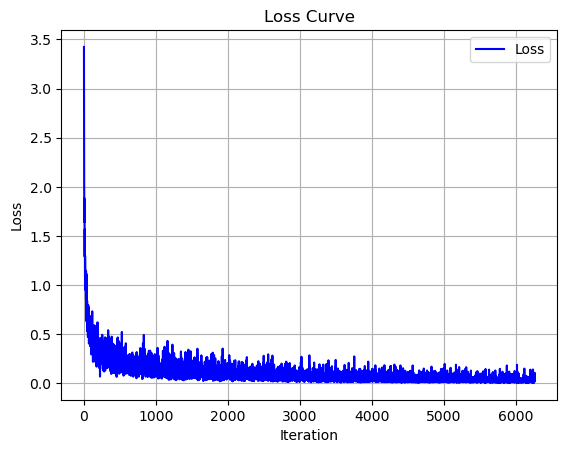

In [33]:
from collections import deque
import matplotlib.pyplot as plt
epoch_num=20
model=MLP(784,10)
learning_rate=0.001
N=10
dq=deque(maxlen=N)
g_squaresum=[0]*10
loss_values=[]
for epoch in range(epoch_num):
    for batch_idx, (x, y) in enumerate(train_loader):

        batch_s=x.shape[0]
        softmax_out=model.forward(x) #[64,10]
        loss=CrossEntropyloss(softmax_out,y) #[64,]
        g=model.backward()
        g_lout=softmax_out+0
        g_lout[torch.arange(g_lout.shape[0]),y]-=1 #[64,10],loss对output导数
        g[0]=g[0]*g_lout.reshape(batch_s,1,-1) #[64,128,10]
        g[1]=g[1]*g_lout #[64,10]
        g[2]=(g[2]@g_lout.reshape(batch_s,-1,1)).reshape(batch_s,-1) #[64,128]
        g[3]=(g[3]@g_lout.reshape(batch_s,-1,1)).reshape(batch_s,-1) #[64,128]
        g[4]=(g[4]@g_lout.reshape(batch_s,1,-1,1)).reshape(batch_s,g[4].shape[1],-1) #[64,256,128]
        g[5]=(g[5]@g_lout.reshape(batch_s,-1,1)).reshape(batch_s,-1) #[64,128]
        g[6]=(g[6]@g_lout.reshape(batch_s,-1,1)).reshape(batch_s,-1) #[64,256]
        g[7]=(g[7]@g_lout.reshape(batch_s,-1,1)).reshape(batch_s,-1) #[64,256]
        g[8]=(g[8]@g_lout.reshape(batch_s,1,-1,1)).reshape(batch_s,g[8].shape[1],-1) #[64,784,256]
        g[9]=(g[9]@g_lout.reshape(batch_s,-1,1)).reshape(batch_s,-1) #[64,256]
        g=[gi.mean(dim=0) for gi in g]
        g_square=[gi**2 for gi in g]
        for i in range(10):
            g_squaresum[i]+=g_square[i]
        if len(dq)<N:
            dq.append(g_square)
        else:
            minuse=dq.popleft()
            dq.append(g_square)
            for i in range(10):
                g_squaresum[i]-=minuse[i]
        for w,gi,gsum in zip(model.weights,g,g_squaresum):
            w-=learning_rate/torch.sqrt(gsum+1e-4)*gi
        if (batch_idx) % 20 == 0:  
            print(f'Epoch [{epoch+1}/{epoch_num}], Step [{batch_idx}/{len(train_loader)}], Loss: {loss.mean().item():.4f}') 
        loss_values.append(loss.mean().numpy())
plt.plot(range(len(loss_values)), loss_values, linestyle='-', color='b', label='Loss')  
plt.title('Loss Curve')  
plt.xlabel('Iteration')  
plt.ylabel('Loss')  
plt.legend()  
plt.grid(True)  
plt.savefig('mlp_loss.png')
plt.show()  

In [34]:
y_hat=model.forward(X_test_tensor)
y_predicted=y_hat.argmax(dim=1).numpy()
martix=np.zeros((10,10),dtype=int)
for true,predicted in zip(y_test,y_predicted):
    martix[true,predicted]+=1
print(martix)
accuracy=martix.trace()/len(y_test)
print('accuracy:',accuracy)
sum_row=np.sum(martix,axis=0)
sum_col=np.sum(martix,axis=1)
Precision=martix.diagonal()/sum_row
Recall=martix.diagonal()/sum_col
print(f'Percision: {np.around(Precision,decimals=3)}')
print(f'Recall: {np.around(Recall,decimals=3)}')
F1=2*Precision*Recall/(Precision+Recall)
print(f'F1: {np.around(F1,decimals=3)}')

[[201   1   1   1   0   1   0   0   0   2]
 [  0 229   0   0   0   0   1   0   0   0]
 [  2   0 195   0   0   0   0   1   0   0]
 [  0   0   1 204   0   0   0   0   2   0]
 [  0   0   1   0 190   0   0   1   0   2]
 [  1   0   0   1   0 163   3   0   1   0]
 [  0   0   0   2   1   0 199   0   0   0]
 [  0   0   5   0   0   0   0 210   0   0]
 [  0   0   0   1   0   3   2   0 181   0]
 [  0   0   0   0   5   1   0   0   0 185]]
accuracy: 0.9785
Percision: [0.985 0.996 0.961 0.976 0.969 0.97  0.971 0.991 0.984 0.979]
Recall: [0.971 0.996 0.985 0.986 0.979 0.964 0.985 0.977 0.968 0.969]
F1: [0.978 0.996 0.973 0.981 0.974 0.967 0.978 0.984 0.976 0.974]
